In [1]:
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
import numpy as np

In [2]:
plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

# 数据清洗

In [3]:
# 1. 导入数据
df = pd.read_csv('house.csv', encoding='gbk')

# 2. 查看数据情况

## 1）数据总体情况
df.shape

(8942, 15)

In [4]:
df.head()

,户型,建筑面积,朝向,楼层,装修,建筑年代,电梯,产权性质,住宅类别,建筑结构,建筑类别,区域,学校,总价,单价
0,2室2厅1卫,104.66平米,南,高层,毛坯,2020年,有,商品房,普通住宅,平层,板楼,城关,0,191.0,18250元/平米
1,1室1厅1卫,48.86平米,南北,中层,简装修,2020年,无,商品房,普通住宅,平层,板楼,城关,1,63.0,12894元/平米
2,1室3厅1卫,80平米,南北,低层,简装修,NaN,无,房改房,NaN,平层,NaN,城关,0,118.0,14750元/平米
3,3室2厅2卫,118.00平米,南北,中楼层,暂无,NaN,NaN,NaN,NaN,NaN,NaN,安宁,0,142.0,12034元/平米
4,3室2厅1卫,94.66平米,南,中层,毛坯,2015年,有,个人产权,普通住宅,平层,板楼,安宁,0,110.0,11621元/平米


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8942 entries, 0 to 8941
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   户型      8942 non-null   object 
 1   建筑面积    8942 non-null   object 
 2   朝向      8942 non-null   object 
 3   楼层      8942 non-null   object 
 4   装修      8942 non-null   object 
 5   建筑年代    6861 non-null   object 
 6   电梯      7083 non-null   object 
 7   产权性质    7083 non-null   object 
 8   住宅类别    6117 non-null   object 
 9   建筑结构    5080 non-null   object 
 10  建筑类别    6446 non-null   object 
 11  区域      8942 non-null   object 
 12  学校      8942 non-null   int64  
 13  总价      8942 non-null   float64
 14  单价      8942 non-null   object 
dtypes: float64(1), int64(1), object(13)
memory usage: 1.0+ MB


In [6]:
#判断是否有重复项,删除
df.duplicated().sum()
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6613 entries, 0 to 8940
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   户型      6613 non-null   object 
 1   建筑面积    6613 non-null   object 
 2   朝向      6613 non-null   object 
 3   楼层      6613 non-null   object 
 4   装修      6613 non-null   object 
 5   建筑年代    5138 non-null   object 
 6   电梯      5307 non-null   object 
 7   产权性质    5307 non-null   object 
 8   住宅类别    4619 non-null   object 
 9   建筑结构    3840 non-null   object 
 10  建筑类别    4829 non-null   object 
 11  区域      6613 non-null   object 
 12  学校      6613 non-null   int64  
 13  总价      6613 non-null   float64
 14  单价      6613 non-null   object 
dtypes: float64(1), int64(1), object(13)
memory usage: 826.6+ KB


In [7]:
#数据格式转换
df.replace('暂无',np.nan,inplace=True)
df['建筑面积'] = df['建筑面积'].map(lambda x: x.replace('平米','')).astype('float')
df['单价'] = df['单价'].map(lambda x: x.replace('元/平米','')).astype('float')
def process_year(year):
    if year is not None:
        year = str(year)[:4]
    return year   
df['建筑年代'] = df['建筑年代'].map(process_year)
floor = {'低楼层': '低','中楼层': '中','高楼层': '高','低层': '低','中层': '中','高层': '高'}
df['楼层'] = df['楼层'].map(floor)
def process_area(area):
    if area != '新区':
        area = area.replace('区','').replace('县','')
    return area   
df['区域'] = df['区域'].map(process_area)
df.replace('nan',np.nan,inplace=True)

In [8]:
df.head()

,户型,建筑面积,朝向,楼层,装修,建筑年代,电梯,产权性质,住宅类别,建筑结构,建筑类别,区域,学校,总价,单价
0,2室2厅1卫,104.66,南,高,毛坯,2020,有,商品房,普通住宅,平层,板楼,城关,0,191.0,18250.0
1,1室1厅1卫,48.86,南北,中,简装修,2020,无,商品房,普通住宅,平层,板楼,城关,1,63.0,12894.0
2,1室3厅1卫,80.00,南北,低,简装修,NaN,无,房改房,NaN,平层,NaN,城关,0,118.0,14750.0
3,3室2厅2卫,118.00,南北,中,NaN,NaN,NaN,NaN,NaN,NaN,NaN,安宁,0,142.0,12034.0
4,3室2厅1卫,94.66,南,中,毛坯,2015,有,个人产权,普通住宅,平层,板楼,安宁,0,110.0,11621.0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6613 entries, 0 to 8940
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   户型      6602 non-null   object 
 1   建筑面积    6613 non-null   float64
 2   朝向      6606 non-null   object 
 3   楼层      6608 non-null   object 
 4   装修      5202 non-null   object 
 5   建筑年代    5138 non-null   object 
 6   电梯      5307 non-null   object 
 7   产权性质    5307 non-null   object 
 8   住宅类别    4619 non-null   object 
 9   建筑结构    3840 non-null   object 
 10  建筑类别    4829 non-null   object 
 11  区域      6613 non-null   object 
 12  学校      6613 non-null   int64  
 13  总价      6613 non-null   float64
 14  单价      6613 non-null   float64
dtypes: float64(3), int64(1), object(11)
memory usage: 826.6+ KB


In [10]:
#查看缺失值
df.isnull().sum()

户型        11
建筑面积       0
朝向         7
楼层         5
装修      1411
建筑年代    1475
电梯      1306
产权性质    1306
住宅类别    1994
建筑结构    2773
建筑类别    1784
区域         0
学校         0
总价         0
单价         0
dtype: int64

In [11]:
# 缺失值处理
# 户型、朝向、楼层处理，缺失值数量不多，考虑直接删除即可
df.dropna(subset=['户型','朝向','楼层'], inplace=True)
# 建筑年代、建筑类别、建筑结构、住宅类别、产权性质、这些离散型变量很难处理，得根据实际情况填充，为了得到更加真实的结果暂不处理
# 电梯处理（底层无，高层有，中层随机处理）
df.loc[(df['楼层'] == '高') & (df['电梯'].isnull()),'电梯'] = '有 '
df.loc[(df['楼层'] == '低') & (df['电梯'].isnull()),'电梯'] = '无 '
df.loc[(df['楼层'] == '中') & (df['电梯'].isnull()),'电梯'] = random.choice(['有 ','无 '])
df.reset_index(drop=True, inplace=True)
df.isnull().sum()

户型         0
建筑面积       0
朝向         0
楼层         0
装修      1400
建筑年代    1465
电梯         0
产权性质    1295
住宅类别    1981
建筑结构    2755
建筑类别    1770
区域         0
学校         0
总价         0
单价         0
dtype: int64

In [12]:
df.describe()

,建筑面积,学校,总价,单价
count,6590.000000,6590.000000,6590.000000,6590.000000
mean,103.020879,0.443399,133.398445,12743.167830
std,39.679701,0.496824,228.675315,17952.153962
min,15.900000,0.000000,14.000000,1167.000000
25%,80.000000,0.000000,83.000000,10248.500000
50%,97.000000,0.000000,114.500000,12064.000000
75%,118.000000,1.000000,148.000000,14104.500000
max,423.430000,1.000000,14500.000000,979730.000000


<Axes: >

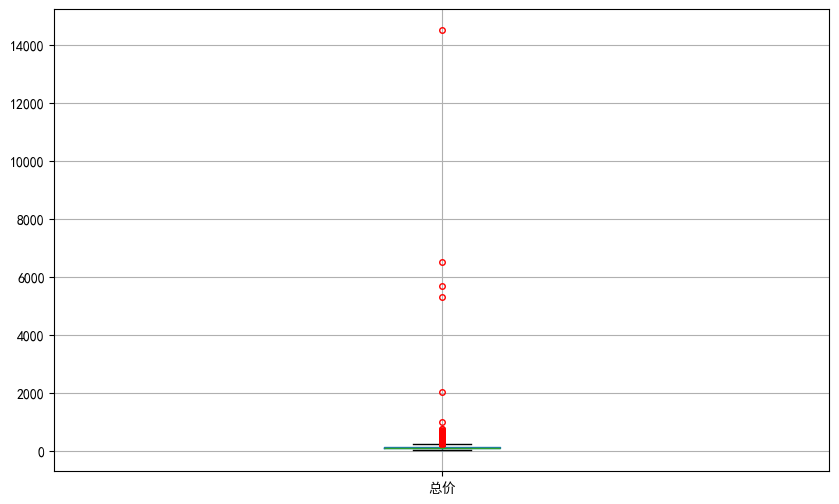

In [13]:
# 箱线图分析
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
fig, ax = plt.subplots(figsize=(10, 6))  # 只创建一个子图
df.boxplot(column=['总价'], flierprops={'markeredgecolor':'red', 'markersize':4})

In [14]:
# 计算总价列的分位数
Q1 = df['总价'].quantile(0.25)  # 下四分位数
Q3 = df['总价'].quantile(0.75)  # 上四分位数
IQR = Q3 - Q1                  # 四分位距

# 定义异常值范围（通常取IQR的1.5倍）
lower_bound = Q1 - 1.5 * IQR   # 下界
upper_bound = Q3 + 1.5 * IQR   # 上界
# 过滤异常值（保留在界内的数据）
df = df[(df['总价'] >= lower_bound) & (df['总价'] <= upper_bound)]
df.shape

(6182, 15)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6182 entries, 0 to 6589
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   户型      6182 non-null   object 
 1   建筑面积    6182 non-null   float64
 2   朝向      6182 non-null   object 
 3   楼层      6182 non-null   object 
 4   装修      4800 non-null   object 
 5   建筑年代    4737 non-null   object 
 6   电梯      6182 non-null   object 
 7   产权性质    4919 non-null   object 
 8   住宅类别    4294 non-null   object 
 9   建筑结构    3585 non-null   object 
 10  建筑类别    4463 non-null   object 
 11  区域      6182 non-null   object 
 12  学校      6182 non-null   int64  
 13  总价      6182 non-null   float64
 14  单价      6182 non-null   float64
dtypes: float64(3), int64(1), object(11)
memory usage: 772.8+ KB


In [16]:
# 另存为新文件
df.to_csv('house01.csv',encoding='utf8',index=False)

# 数据分析

C:\Users\27514\AppData\Local\Temp\ipykernel_28580\568172626.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x, y=y1, ax=ax[0], palette='Blues_r')  # 修正参数传递方式
C:\Users\27514\AppData\Local\Temp\ipykernel_28580\568172626.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x, y=y2, ax=ax[1], palette='BuGn_r')  # 修正参数传递方式
C:\Users\27514\AppData\Local\Temp\ipykernel_28580\568172626.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x, y=y3, ax=ax[2], palette='Oranges_d')  # 修正参数传递方式


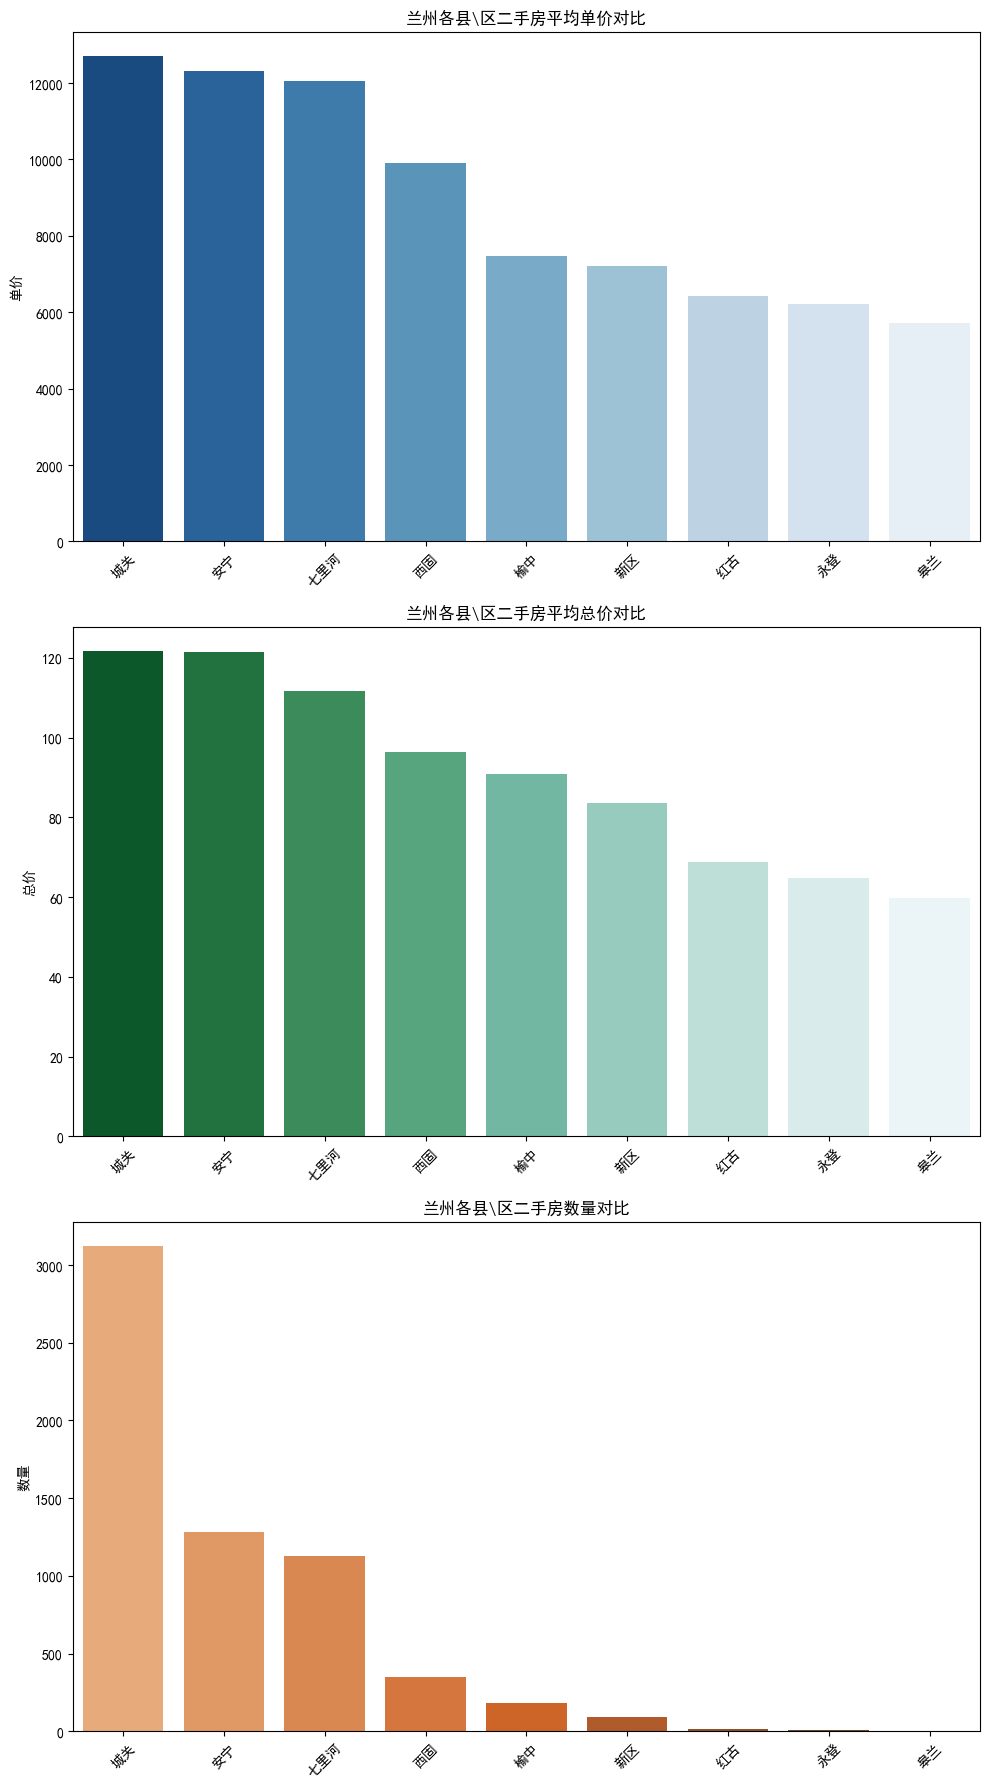

In [17]:
# 相关性
# 1 探究单价、数量、总价和地区的关系
fig, ax = plt.subplots(3, 1, figsize=(10, 18))
x = df['区域'].unique()

# 各区单价对比
y1 = round(df.groupby(by=['区域'])['单价'].mean().sort_values(ascending=False), 2)
sns.barplot(x=x, y=y1, ax=ax[0], palette='Blues_r')  # 修正参数传递方式
ax[0].set_title('兰州各县\区二手房平均单价对比')
ax[0].tick_params(axis='x', rotation=45)  # 旋转x轴标签

# 各区总价对比
y2 = round(df.groupby(by=['区域'])['总价'].mean().sort_values(ascending=False), 2)
sns.barplot(x=x, y=y2, ax=ax[1], palette='BuGn_r')  # 修正参数传递方式
ax[1].set_title('兰州各县\区二手房平均总价对比')
ax[1].tick_params(axis='x', rotation=45)  # 旋转x轴标签

# 各区房子数量对比
y3 = df.groupby(by=['区域']).size().sort_values(ascending=False)  # 无需round整数
sns.barplot(x=x, y=y3, ax=ax[2], palette='Oranges_d')  # 修正参数传递方式
ax[2].set_title('兰州各县\区二手房数量对比')
ax[2].set_ylabel('数量')
ax[2].tick_params(axis='x', rotation=45)  # 旋转x轴标签

plt.tight_layout()  # 自动调整布局
plt.show()

各区二手房平均单价、总价、数量都是一样的排列顺序，最高的是城关区，最低的是皋兰县。

<Axes: xlabel='建筑面积', ylabel='总价'>

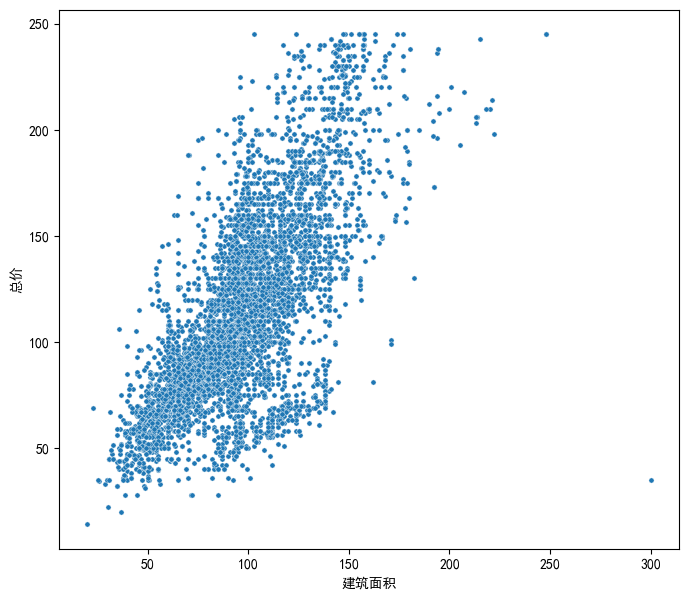

In [18]:
#探究面积和总价的关系
plt.figure(figsize=(8,7))
sns.scatterplot(x='建筑面积',y='总价',data=df,s=14)


<Axes: xlabel='朝向', ylabel='总价'>

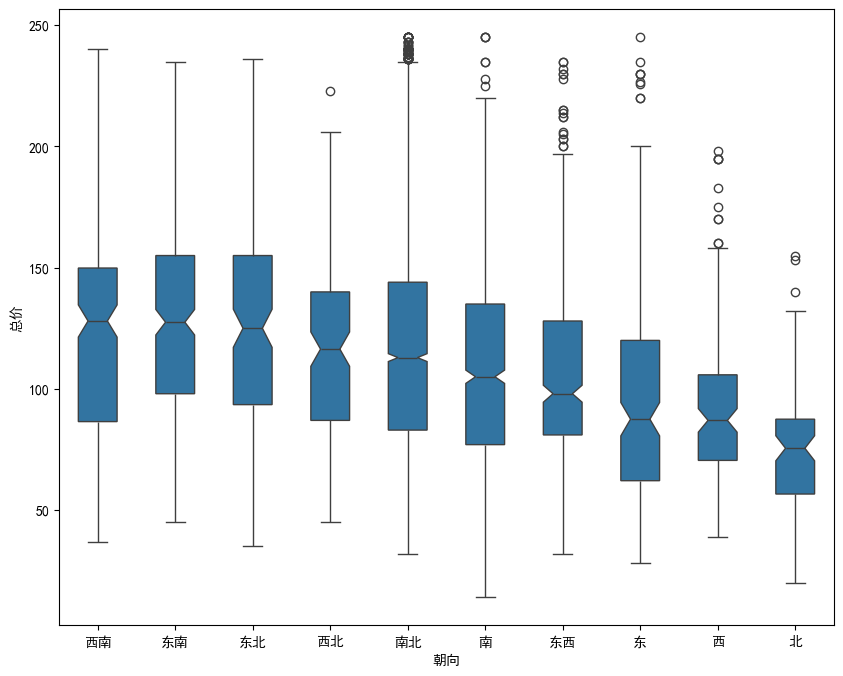

In [19]:
# 探究朝向和总价的关系
plt.figure(figsize=(10,8))
my_order = df.groupby(by=["朝向"])["总价"].median().sort_values(ascending=False).index
sns.boxplot(x='朝向',y='总价',data=df,width=0.5,notch=True,order=my_order)


风水：人们在挑选房子时，经常喜欢挑坐北朝南的房子，因为这种房子采光好，顺光顺水，冬暖夏凉，很适合人居住。
包含南、北朝向方位的价格相对来说要贵一点。

<Axes: xlabel='装修', ylabel='总价'>

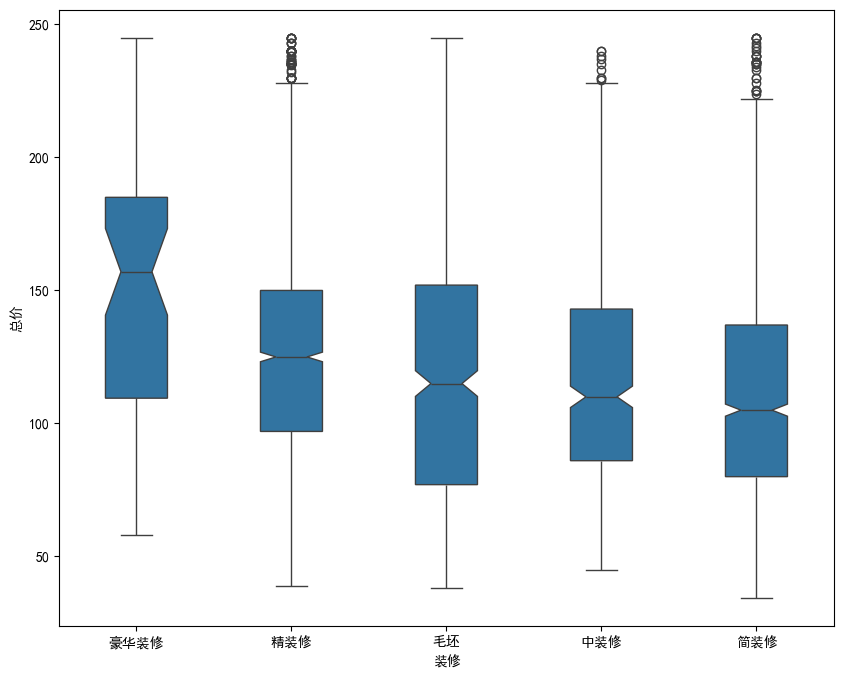

In [20]:
# 探究装修和总价的关系
plt.figure(figsize=(10,8))
my_order = df.groupby(by=["装修"])["总价"].median().sort_values(ascending=False).index
sns.boxplot(x='装修',y='总价',data=df,width=0.4,notch=True,order=my_order)



不同装修信息对总价是有一定影响的，装修情况越好价格会偏高一点。

<Axes: xlabel='楼层', ylabel='总价'>

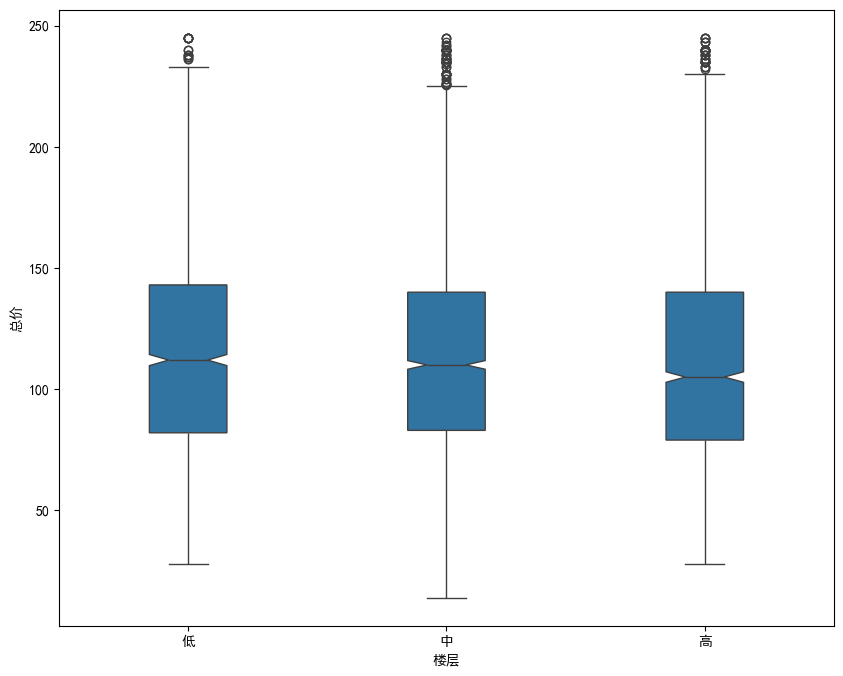

In [21]:
#探究楼层和总价的关系
plt.figure(figsize=(10,8))
my_order = df.groupby(by=["楼层"])["总价"].median().sort_values(ascending=False).index
sns.boxplot(x='楼层',y='总价',data=df,width=0.3,notch=True,order=my_order)

不同楼层对总价影响较小。

<Axes: xlabel='电梯', ylabel='总价'>

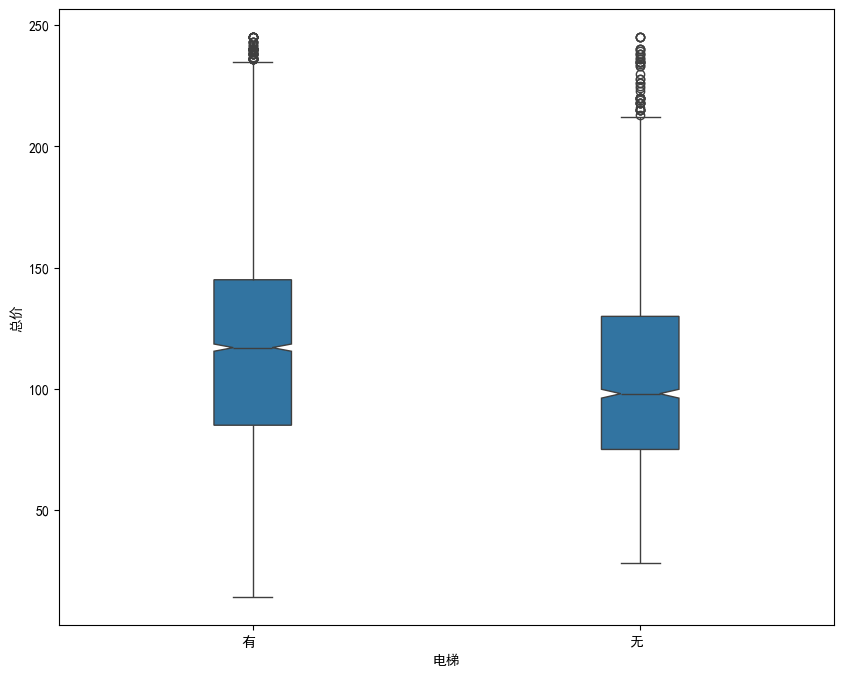

In [22]:
#探究电梯和总价的关系
plt.figure(figsize=(10,8))
my_order = df.groupby(by=["电梯"])["总价"].median().sort_values(ascending=False).index
sns.boxplot(x='电梯',y='总价',data=df,width=0.2,notch=True,order=my_order)

<Axes: xlabel='学校', ylabel='总价'>

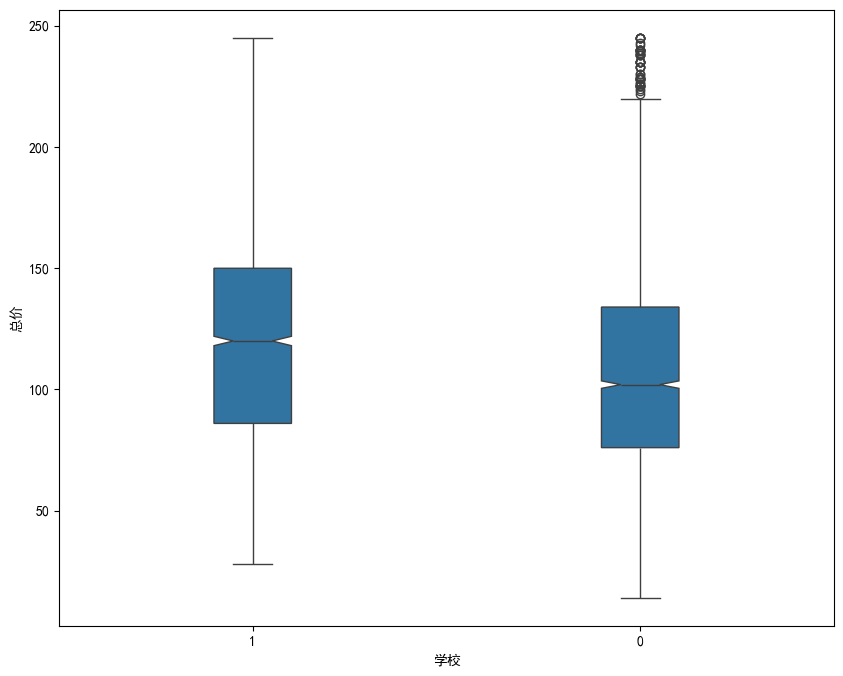

In [23]:
#探究学区房和总价的关系
plt.figure(figsize=(10,8))
my_order = df.groupby(by=["学校"])["总价"].median().sort_values(ascending=False).index
sns.boxplot(x='学校',y='总价',data=df,width=0.2,notch=True,order=my_order)



<Axes: xlabel='产权性质', ylabel='总价'>

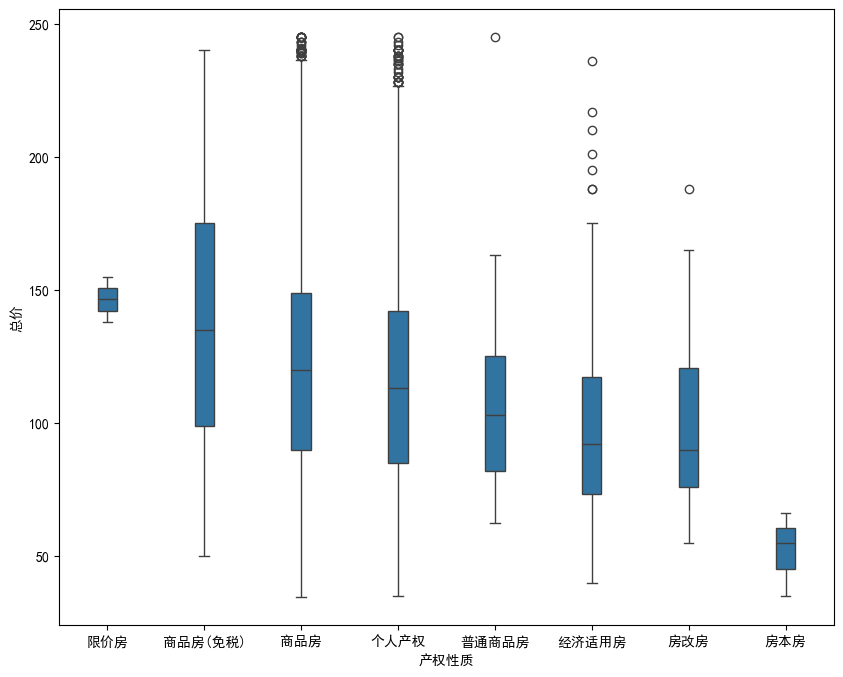

In [24]:
#产权性质、住宅类别、建筑结构、建筑类别与总价的关系
plt.figure(figsize=(10,8))
my_order = df.groupby(by=["产权性质"])["总价"].median().sort_values(ascending=False).index
sns.boxplot(x='产权性质',y='总价',data=df,width=0.2,order=my_order)

<Axes: xlabel='住宅类别', ylabel='总价'>

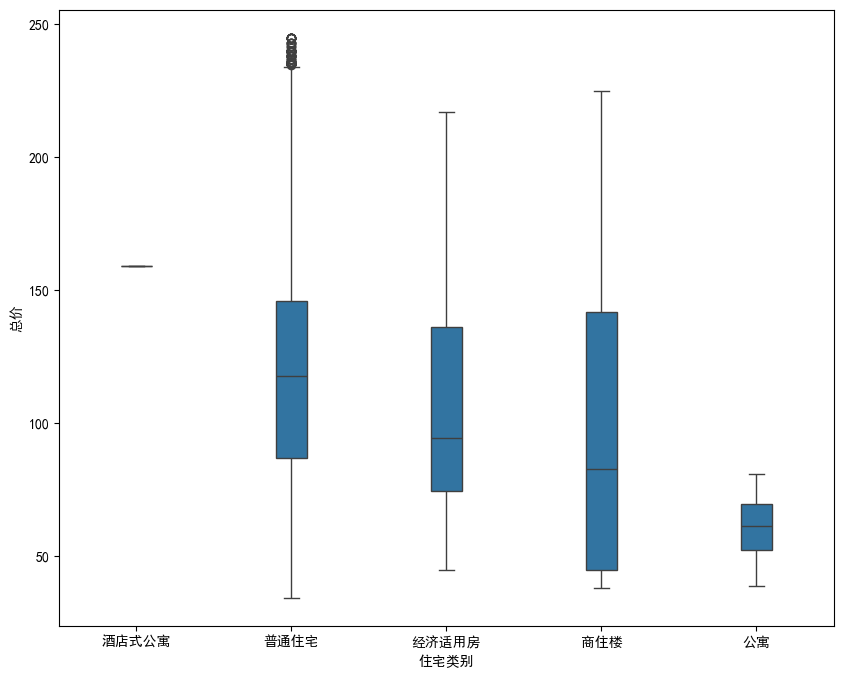

In [25]:
plt.figure(figsize=(10,8))
my_order = df.groupby(by=["住宅类别"])["总价"].median().sort_values(ascending=False).index
sns.boxplot(x='住宅类别',y='总价',data=df,width=0.2,order=my_order)

<Axes: xlabel='建筑结构', ylabel='总价'>

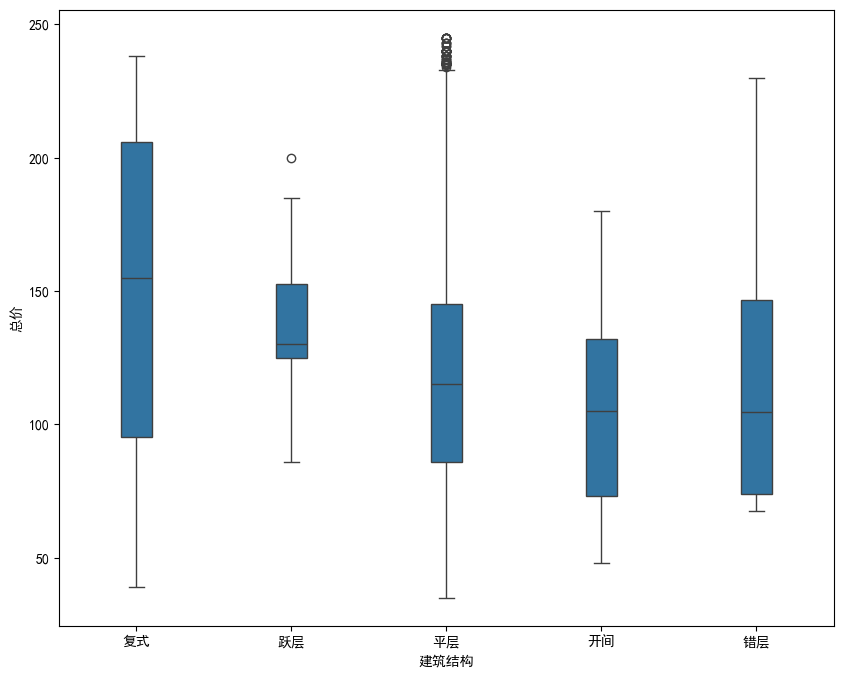

In [26]:
plt.figure(figsize=(10,8))
my_order = df.groupby(by=["建筑结构"])["总价"].median().sort_values(ascending=False).index
sns.boxplot(x='建筑结构',y='总价',data=df,width=0.2,order=my_order)

<Axes: xlabel='建筑类别', ylabel='总价'>

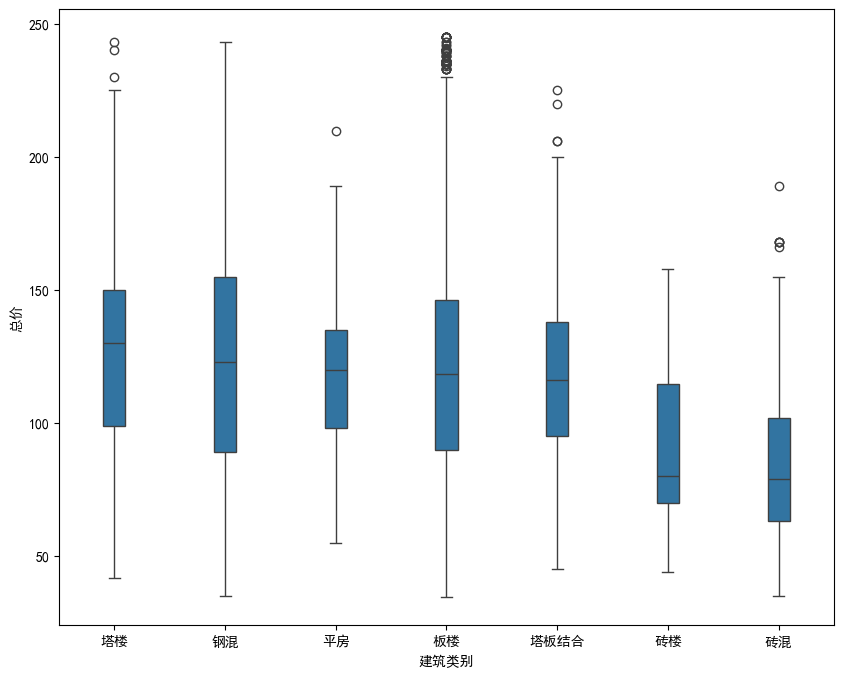

In [27]:
plt.figure(figsize=(10,8))
my_order = df.groupby(by=["建筑类别"])["总价"].median().sort_values(ascending=False).index
sns.boxplot(x='建筑类别',y='总价',data=df,width=0.2,order=my_order)

<Axes: xlabel='总价', ylabel='户型'>

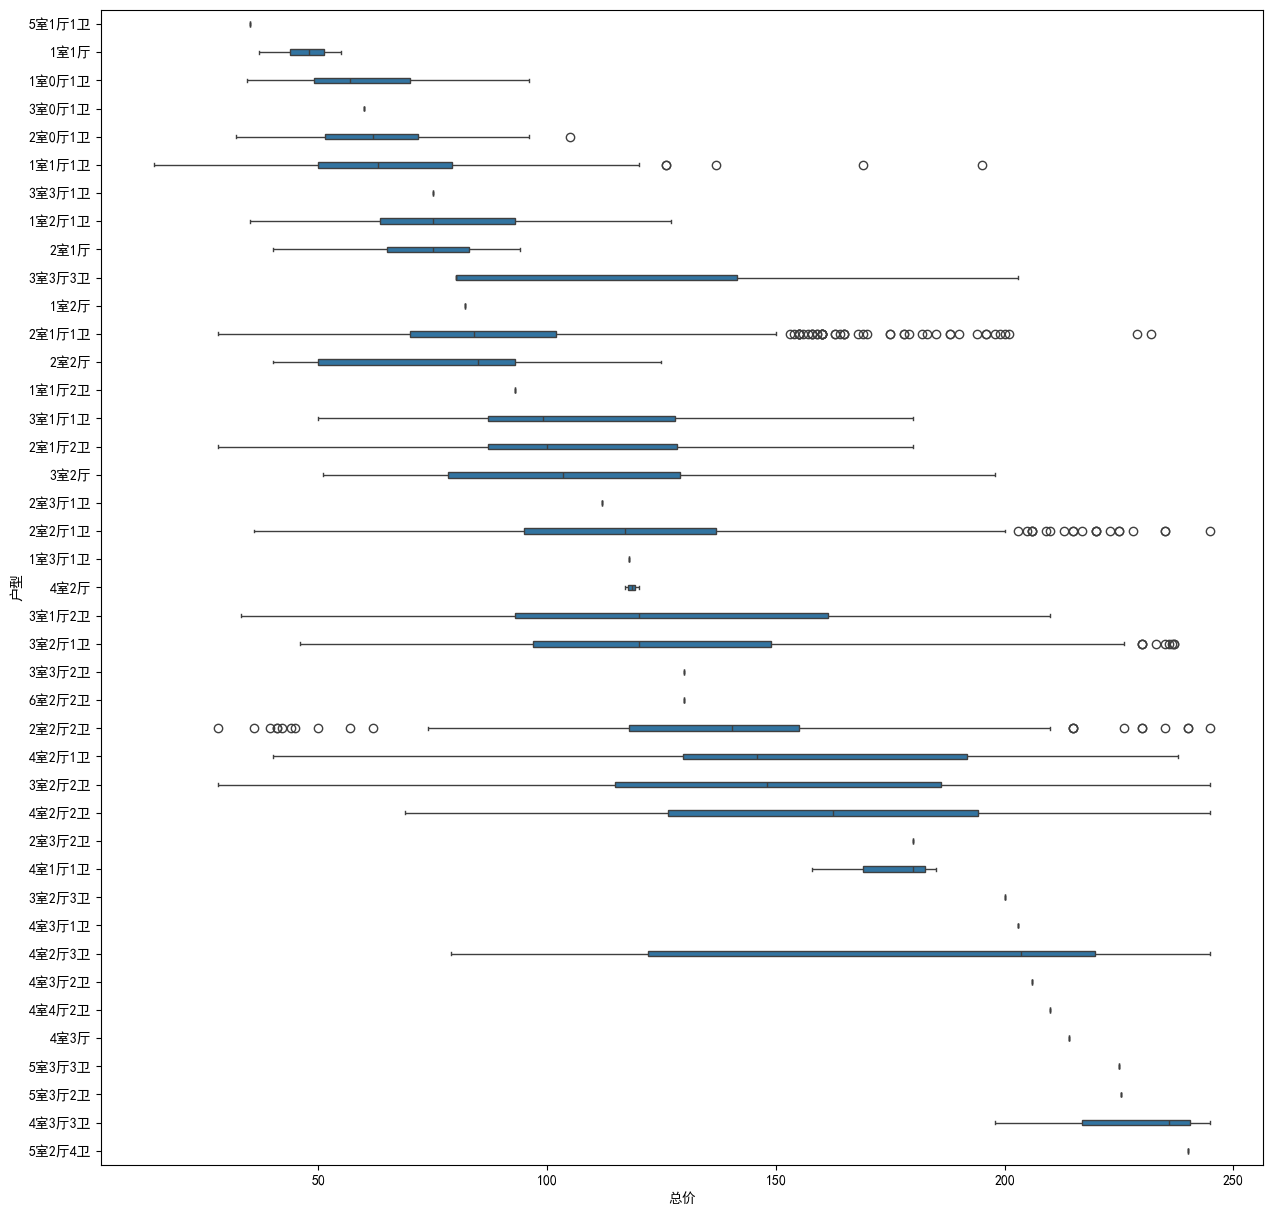

In [28]:
# 户型与总价关系
plt.figure(figsize=(15,15))
my_order = df.groupby(by=["户型"])["总价"].median().sort_values().index
sns.boxplot(y='户型',x='总价',data=df,width=0.2,order=my_order)

<Axes: xlabel='count', ylabel='户型'>

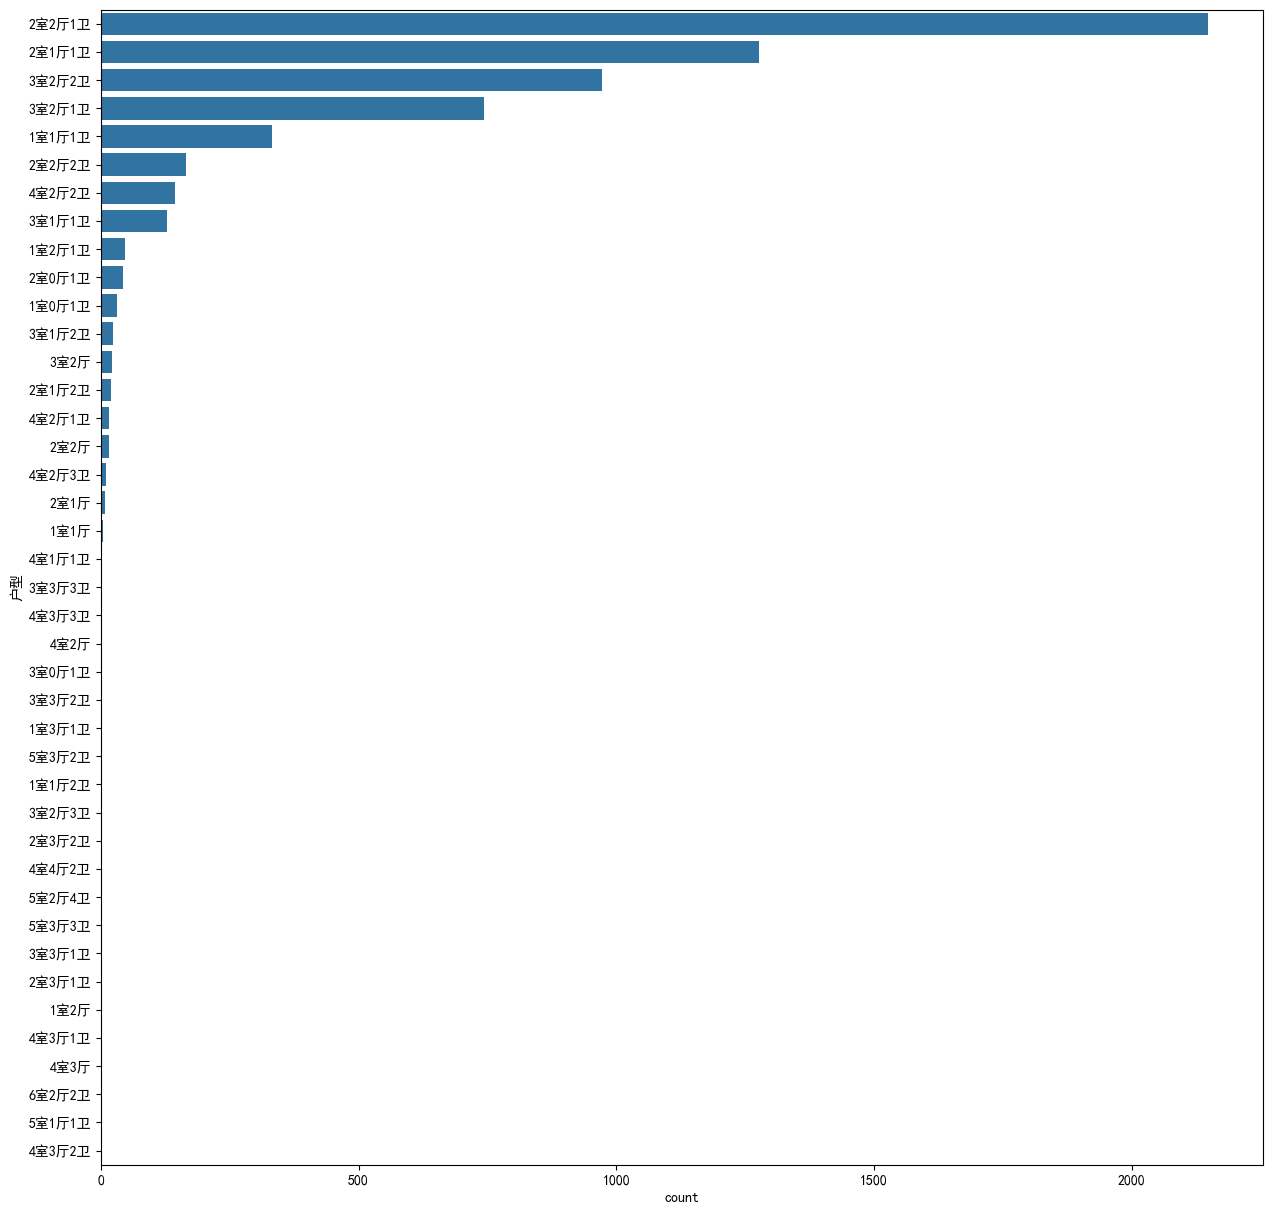

In [29]:
#按户型数量排序的柱形图
plt.figure(figsize=(15,15))
order = df['户型'].value_counts(ascending=False).index
sns.countplot(y=df['户型'],order=order)

户型对总价影响比较大，不同的室、厅、卫又会产生不同的影响。
大多数需求集中在 2或3 室 1或2 厅 1或2 卫。

In [30]:
#特征化工程，以便后续能够很好的进行预测等等
# 删除所有缺失值
d1 = df.dropna().reset_index(drop=True)
# 分解户型
def apart_room(x):
    room = x.split('室')[0]
    return int(room)
def apart_hall(x):
    hall = x.split('厅')[0].split('室')[1]
    return int(hall)
def apart_wc(x):
    wc = x.split('卫')[0].split('厅')[1]
    return int(wc)
d1['室'] = d1['户型'].map(apart_room)
d1['厅'] = d1['户型'].map(apart_hall)
d1['卫'] = d1['户型'].map(apart_wc)
# 删除楼层、户型、单价
d1.drop(columns=['户型','楼层','单价'],inplace=True)
# 编码-有序多分类（根据上面可视化的结果，按照对价格的影响程度排序，越大影响越高）
# 无序多分类无法直接引入，必须“哑元”化变量
# 等级变量（有序多分类）可以直接引入模型
map1 = {'南':5, '南北':6, '北':1, '西南':10, '东西':4, '东':2, '东北':8, '东南':9, '西':3, '西北':7}
d1['朝向'] = d1['朝向'].map(map1)
map2 = {'毛坯':1, '简装修':2, '精装修':3, '中装修':4, '豪华装修':5}
d1['装修'] = d1['装修'].map(map2)
map3 = {'有 ':1, '无 ':0}
d1['电梯'] = d1['电梯'].map(map3)
map4 = {'商品房':6, '个人产权':5, '商品房(免税)':7, '普通商品房':4, '经济适用房':2, '房改房':3, '限价房':8, '房本房':1}
d1['产权性质'] = d1['产权性质'].map(map4)
map5 = {'普通住宅':4, '经济适用房':3, '公寓':1, '商住楼':2, '酒店式公寓':5}
d1['住宅类别'] = d1['住宅类别'].map(map5)
map6 = {'平层':4, '开间':2, '跃层':5, '错层':1, '复式':3}
d1['建筑结构'] = d1['建筑结构'].map(map6)
map7 = {'板楼':4, '钢混':5, '塔板结合':3, '平房':6, '砖混':1, '塔楼':7, '砖楼':2}
d1['建筑类别'] = d1['建筑类别'].map(map7)
map8 = {'城关':6, '安宁':5, '七里河':4, '西固':3,'榆中':2, '永登':1}
d1['区域'] = d1['区域'].map(map8)
# 删除超过2019年的房子，年代转变为房龄
d1['建筑年代'] = d1['建筑年代'].astype('int32')
d1.drop(index=d1[d1['建筑年代']>2019].index,inplace=True)
d1['房龄'] = d1['建筑年代'].map(lambda x: 2020-x)
d1.drop(columns=['建筑年代'],inplace=True)

In [31]:
d1.head()

,建筑面积,朝向,装修,电梯,产权性质,住宅类别,建筑结构,建筑类别,区域,学校,总价,室,厅,卫,房龄
2,94.66,5,1,1,5,4,4,4,5,0,110.0,3,2,1,5
3,92.50,5,3,0,6,4,4,4,5,0,133.8,2,2,1,6
4,60.00,1,3,0,5,4,4,5,6,1,70.0,2,1,1,17
5,110.00,6,1,1,5,4,4,3,6,0,102.0,3,2,2,3
6,56.80,5,3,0,5,4,4,4,6,1,66.0,1,1,1,17


In [32]:
# 另存为新文件
d1.to_csv('house02.csv',encoding='utf8',index=False)

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 假设目标变量是总价
X = d1.drop('总价', axis=1)
y = d1['总价']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 定义模型
models = {
    '线性回归': LinearRegression(),
    '决策树回归': DecisionTreeRegressor(random_state=42),
    'K近邻回归': KNeighborsRegressor(),
    '岭回归': Ridge(random_state=42),
    'Lasso回归': Lasso(random_state=42, alpha=0.1),
    '随机森林回归': RandomForestRegressor(random_state=42)
}

# 存储模型评估结果
results = []

# 遍历模型并进行训练和评估
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        '模型': model_name,
        '均方误差(MSE)': mse,
        '决定系数(R²)': r2
    })

# 将结果转换为 DataFrame 以便查看
results_df = pd.DataFrame(results)
results_df

,模型,均方误差(MSE),决定系数(R²)
0,线性回归,579.646947,0.689081
1,决策树回归,809.926815,0.565560
2,K近邻回归,560.239851,0.699490
3,岭回归,579.438148,0.689193
4,Lasso回归,576.057799,0.691006
5,随机森林回归,444.625576,0.761505


In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 读取数据时指定UTF-8编码
df = pd.read_csv('house02.csv', encoding='utf-8')

# 数据处理...
X = df.drop('总价', axis=1)
y = df['总价']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 定义模型
base_models = [
    ('随机森林', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)),
    ('岭回归', Ridge(alpha=1.0, random_state=42)),
    ('Lasso回归', Lasso(alpha=0.1, random_state=42, max_iter=10000))
]
meta_model = Ridge(random_state=42)
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5, passthrough=True)
stacking_model.fit(X_train, y_train)
y_pred = stacking_model.predict(X_test)

# 评估模型
def calculate_metrics(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {
        '模型': model_name,
        '均方误差(MSE)': mse,
        '均方根误差(RMSE)': rmse,
        '决定系数(R²)': r2
    }

results = []
for name, model in base_models:
    model.fit(X_train, y_train)
    results.append(calculate_metrics(y_test, model.predict(X_test), name))
results.append(calculate_metrics(y_test, y_pred, 'Stacking集成'))
results_df = pd.DataFrame(results).sort_values('决定系数(R²)', ascending=False)

# 关键修改：打印时指定UTF-8编码
print("模型性能对比：")
print(results_df.to_csv(sep='\t', na_rep='nan', encoding='utf-8', header=True))

# 特征重要性分析...
rf_model = base_models[0][1]
rf_model.fit(X_train, y_train)
rf_importance = pd.DataFrame({
    '特征': X.columns,
    '重要性': rf_model.feature_importances_
}).sort_values('重要性', ascending=False)

print("\n随机森林特征重要性（前10名）：")
print(rf_importance.head(10).to_csv(sep='\t', na_rep='nan', encoding='utf-8', header=True))

模型性能对比：
	模型	均方误差(MSE)	均方根误差(RMSE)	决定系数(R²)
3	Stacking集成	429.2014590521991	20.717177873740408	0.769778721737107
0	随机森林	444.62557635113643	21.086146550546793	0.7615053109046283
2	Lasso回归	576.0577993030776	24.001204121940997	0.6910057966677732
1	岭回归	579.4381484109098	24.071521522556687	0.6891925961854205


随机森林特征重要性（前10名）：
	特征	重要性
0	建筑面积	0.7498230623111238
13	房龄	0.08342757727617113
8	区域	0.04447597048488435
1	朝向	0.029586522615434672
2	装修	0.018642827984390483
4	产权性质	0.017320170465711073
9	学校	0.014486113005269861
7	建筑类别	0.012640895852124637
10	室	0.009725891197340911
3	电梯	0.00865248079655525



In [35]:
df.head()

,建筑面积,朝向,装修,电梯,产权性质,住宅类别,建筑结构,建筑类别,区域,学校,总价,室,厅,卫,房龄
0,94.66,5,1,1,5,4,4,4,5,0,110.0,3,2,1,5
1,92.50,5,3,0,6,4,4,4,5,0,133.8,2,2,1,6
2,60.00,1,3,0,5,4,4,5,6,1,70.0,2,1,1,17
3,110.00,6,1,1,5,4,4,3,6,0,102.0,3,2,2,3
4,56.80,5,3,0,5,4,4,4,6,1,66.0,1,1,1,17


In [36]:
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score  # 新增：导入 r2_score
import pandas as pd
import xgboost as xgb  # 新增：导入 xgboost

# 读取数据
df = pd.read_csv('house02.csv', encoding='utf-8')

X = df.drop('总价', axis=1)
y = df['总价']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 基础模型
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42
)

knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=9, weights='distance', p=1))
])

# 修改：使用 xgb.XGBRegressor
xgb_reg = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

elastic_net = Pipeline([
    ('scaler', StandardScaler()),
    ('elastic', ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42))
])

# 基础模型集合
estimators = [
    ('rf', rf),
    ('knn', knn_pipeline),
    ('xgb', xgb_reg),  # 修改：使用 xgb_reg
    ('elastic_net', elastic_net)
]

# 元模型（使用Ridge回归学习权重）
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(alpha=1.0),
    cv=5
)

# 训练与评估
stacking_model.fit(X_train, y_train)
y_pred = stacking_model.predict(X_test)
print(f"Stacking集成R²: {r2_score(y_test, y_pred):.4f}")

Stacking集成R²: 0.7777


In [37]:
import joblib#保存模型
joblib.dump(stacking_model,'stacking_model.pkl')

['stacking_model.pkl']

In [38]:
# 修正切片语法：选择前1001行数据作为测试集
X_test = df.iloc[995:1001].drop('总价', axis=1)  # 使用 .iloc 进行整数位置切片

# 预测
y_pred = stacking_model .predict(X_test)

print(y_pred)

[ 43.89407195 152.91932508  90.8971507  190.65848962 147.65676298
 131.1146794 ]


In [39]:
y_pred = stacking_model .predict([[94.66,5,1,1,5,4,4,4,5,0,3,2,1,5]])
print(y_pred)

[115.40450327]


D:\anaconda3\envs\GZY\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\GZY\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\GZY\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [40]:
import joblib
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
# 加载测试数据
df= pd.read_csv('house02.csv')

In [41]:
df.head()

,建筑面积,朝向,装修,电梯,产权性质,住宅类别,建筑结构,建筑类别,区域,学校,总价,室,厅,卫,房龄
0,94.66,5,1,1,5,4,4,4,5,0,110.0,3,2,1,5
1,92.50,5,3,0,6,4,4,4,5,0,133.8,2,2,1,6
2,60.00,1,3,0,5,4,4,5,6,1,70.0,2,1,1,17
3,110.00,6,1,1,5,4,4,3,6,0,102.0,3,2,2,3
4,56.80,5,3,0,5,4,4,4,6,1,66.0,1,1,1,17


In [42]:
# 加载模型和编码器

# 加载模型
model = joblib.load('stacking_model.pkl')

# 读取数据
df = pd.read_csv('house02.csv')

# 修正切片语法：选择前1001行数据作为测试集
X_test = df.iloc[:1001].drop('总价', axis=1)  # 使用 .iloc 进行整数位置切片

# 预测
y_pred = model.predict(X_test)

print(f"预测完成，共{len(y_pred)}个样本")

预测完成，共1001个样本
